# Compare 10x & Hydrop using the validated Mouse Cortex enhancers

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import crested
import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from contextlib import redirect_stderr, redirect_stdout
from io import StringIO
from tqdm import tqdm

# Import scoring utilities from reference notebook
from scoring_utils import *

mpl.rcParams['pdf.fonttype'] = 42

# Comprehensive TensorFlow/XLA warning suppression
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['XLA_FLAGS'] = '--xla_hlo_profile=false --xla_dump_to=/tmp/xla_dumps'
os.environ['CUDA_VISIBLE_DEVICES'] = os.environ.get('CUDA_VISIBLE_DEVICES', '0')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Suppress all warnings
warnings.filterwarnings('ignore')

# Additional TensorFlow configuration
tf.config.experimental.enable_op_determinism()
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

2025-07-29 10:00:51.740292: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 10:00:51.759338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753776051.776317 2186393 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753776051.781427 2186393 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753776051.794196 2186393 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
data_files_root = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_data/anndatas"
anndata_10x_path = os.path.join(data_files_root, "10x_allcells_allreads/normalized_specific.h5ad")
anndata_hydrop_path = os.path.join(data_files_root, "hydrop_allcells_allreads/normalized_specific.h5ad")
checkpoint_root = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_models/finetuned"

genome_path = "../../../../../../../data/genomes/refdata-cellranger-arc-mm10-2020-A-2.0.0/fasta/genome.fa"

In [3]:
# Load mm10 genome
genome = crested.Genome(genome_path, name="mm10")
crested.register_genome(genome)

experiments = ["allcells_allreads", "allcells_36kreads", "limitedcells_allreads", "limitedcells_36kreads"]
technologies = ["10x", "hydrop"]

# Model paths organized by technology, experiment
model_paths = {}
anndata_paths = {}
for tech in technologies:
    anndata_paths[tech] = {}
    model_paths[tech] = {}
    for exp in experiments:
        folder_name = f"{tech}_{exp}"
        model_paths[tech][exp] = f"{checkpoint_root}/{folder_name}/"
        anndata_paths[tech][exp] = f"{data_files_root}/{folder_name}/normalized_specific.h5ad"
        if not os.path.exists(model_paths[tech][exp]):
            raise FileNotFoundError(f"Model path does not exist: {model_paths[tech][exp]}")
        if not os.path.exists(anndata_paths[tech][exp]):
            raise FileNotFoundError(f"Anndata path does not exist: {anndata_paths[tech][exp]}")

print(f"Model folder path example: {model_paths['10x']['allcells_36kreads']}")
print(f"Anndata path example: {anndata_paths['hydrop']['limitedcells_allreads']}")

2025-07-29T10:04:07.495209+0200 INFO Genome mm10 registered.
Model folder path example: ../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_models/finetuned/10x_allcells_36kreads/
Anndata path example: ../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_data/anndatas/hydrop_limitedcells_allreads/normalized_specific.h5ad


In [5]:
# Load validated enhancers data
enhancers_path = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_data/biccn_enhancers.csv"
df_enhancers = pd.read_csv(enhancers_path)

# Filter for mouse enhancers only 
df_mouse = df_enhancers[df_enhancers['species'] == 'mouse'].copy()

df_mouse.head()

,old_idx,chrom,start,end,name,target_ct,second_target_ct,specificity,strength,enhancerID,species
0,9,chr1,46868072,46868423,chr1:46868072-46868423,L6_IT_Car3,NaN,On-Target,strong,AiE2051m,mouse
1,18,chr1,81508154,81508487,chr1:81508154-81508487,SstChodl,NaN,On-Target,strong,AiE0465m,mouse
2,19,chr1,90560790,90561290,chr1:90560790-90561290,Sncg,NaN,On-Target,strong,AiE0492m,mouse
3,21,chr1,120215946,120216285,chr1:120215946-120216285,L5ET,NaN,On-Target,strong,AiE0462m,mouse
4,25,chr1,126153519,126154399,chr1:126153519-126154399,L5_6NP,NaN,On-Target,weak,AiE2443m,mouse


In [7]:
# Cell type mapping - map enhancer annotations to model cell types
cell_type_mapping = {
    'Astro': 'Astro',
    'Endo': 'Endo_VLMC',  
    'L2_3IT': 'L2_3_IT',  
    'L5IT': 'L5_IT',      
    'L5ET': 'L5_ET',      
    'L5_6NP': 'L5_6_NP',  
    'L6CT': 'L6_CT',      
    'L6IT': 'L6_IT',      
    'L6b': 'L6b',
    'Lamp5': 'Lamp5',
    'Micro_PVM': 'Micro_PVM',
    'OPC': 'OPC',
    'Oligo': 'Oligo',
    'Pvalb': 'Pvalb',
    'Sncg': 'Sncg_Vip',   
    'Sst': 'Sst',
    'SstChodl': 'Sst',    
    'VLMC': 'Endo_VLMC',  
    'Vip': 'Sncg_Vip',    
    'L4IT': 'L5_IT',      # Map L4IT to L5_IT 
    'L6_IT_Car3': 'L6_IT', # Map L6_IT_Car3 to L6_IT 
    'Lamp5_Lhx6': 'Lamp5', # Map Lamp5_Lhx6 to Lamp5 
    'Pvalb_Chc': 'Pvalb',  # Map Pvalb_Chc to Pvalb 
}

# Apply mapping
df_mouse['target_ct_mapped'] = df_mouse['target_ct'].map(cell_type_mapping)
df_mouse['second_target_ct_mapped'] = df_mouse['second_target_ct'].map(cell_type_mapping)

# Check for unmapped cell types
unmapped = df_mouse[df_mouse['target_ct_mapped'].isna()]['target_ct'].unique()
if len(unmapped) > 0:
    print(f"Warning: Unmapped cell types: {unmapped}")
else:
    print("All cell types successfully mapped!")

# Get the standard model cell type order (we'll load this from an anndata file)
sample_adata_path = anndata_paths['10x']['allcells_allreads']
sample_adata = anndata.read_h5ad(sample_adata_path)
model_cell_types = list(sample_adata.obs_names)

print(f"Model cell types ({len(model_cell_types)}): {model_cell_types}")

All cell types successfully mapped!
Model cell types (16): ['Astro', 'Endo_VLMC', 'L2_3_IT', 'L5_6_NP', 'L5_ET', 'L5_IT', 'L6_CT', 'L6_IT', 'L6b', 'Lamp5', 'Micro_PVM', 'OPC', 'Oligo', 'Pvalb', 'Sncg_Vip', 'Sst']


In [8]:
def pad_enhancer_sequences(df_mouse, target_length=2114):
    """
    Pad enhancer sequences to target length by fetching genomic sequence 
    and centering the enhancer within N-padded regions.
    """
    padded_sequences = []
    
    for idx, row in tqdm(df_mouse.iterrows(), total=len(df_mouse), desc="Preparing sequences"):
        chrom = row['chrom']
        start = int(row['start'])
        end = int(row['end'])
        enhancer_length = end - start
        
        # Calculate padding needed
        padding_needed = target_length - enhancer_length
        if padding_needed < 0:
            # If enhancer is longer than target, truncate from center
            center = (start + end) // 2
            half_target = target_length // 2
            start = center - half_target
            end = center + half_target
            enhancer_seq = genome.fetch(chrom, start, end)
            padded_seq = enhancer_seq
        else:
            # Fetch the actual enhancer sequence
            enhancer_seq = genome.fetch(chrom, start, end)
            
            # Add N padding to center the enhancer
            left_padding = padding_needed // 2
            right_padding = padding_needed - left_padding
            padded_seq = 'N' * left_padding + enhancer_seq + 'N' * right_padding
        
        # Ensure exactly target_length
        if len(padded_seq) != target_length:
            if len(padded_seq) > target_length:
                # Truncate from center
                excess = len(padded_seq) - target_length
                start_trim = excess // 2
                padded_seq = padded_seq[start_trim:start_trim + target_length]
            else:
                # Add more N padding
                missing = target_length - len(padded_seq)
                padded_seq = padded_seq + 'N' * missing
        
        padded_sequences.append(padded_seq)
    
    return padded_sequences

# Generate padded sequences
enhancer_sequences = pad_enhancer_sequences(df_mouse)
print(f"Generated {len(enhancer_sequences)} sequences of length {len(enhancer_sequences[0])}")
print(f"Centre of sample sequence: {enhancer_sequences[0][len(enhancer_sequences[0]) // 2 - 10:len(enhancer_sequences[0]) // 2 + 10]}")

Preparing sequences: 100%|██████████| 122/122 [00:00<00:00, 849.30it/s] 

Generated 122 sequences of length 2114
Centre of sample sequence: CCAAAGTCTATATTCTGAGT


In [10]:
def load_models_and_predict(tech, exp, sequences, n_folds=10):
    """
    Load all fold models for a technology/experiment and generate averaged predictions.
    """
    # Load models
    model_dir = model_paths[tech][exp]
    models = []
    for fold in range(n_folds):
        model_path = os.path.join(model_dir, f"fold_{fold}.keras")
        with redirect_stderr(StringIO()), redirect_stdout(StringIO()):
            model = keras.models.load_model(model_path, compile=False)
        models.append(model)
    
    # Generate predictions for each fold
    all_predictions = []
    for fold, model in enumerate(models):
        with redirect_stderr(StringIO()), redirect_stdout(StringIO()):
            preds = crested.tl.predict(input=sequences, model=model, verbose=0)
        all_predictions.append(preds)
    
    # Average predictions across folds
    avg_predictions = np.mean(all_predictions, axis=0)
    
    return avg_predictions

# Generate predictions for all technology/experiment combinations (finetune models only)
all_predictions = {}

for tech in technologies:
    all_predictions[tech] = {}
    print(f"=== Processing {tech.upper()} ===\n")
    
    for exp in experiments:
        print(f"Experiment: {exp}...")
        try:
            predictions = load_models_and_predict(tech, exp, enhancer_sequences)
            all_predictions[tech][exp] = predictions
        except Exception as e:
            print(f"Error processing {tech} {exp}: {e}")
            # Create dummy predictions as fallback
            all_predictions[tech][exp] = np.zeros((len(enhancer_sequences), len(model_cell_types)))

=== Processing 10X ===

Experiment: allcells_allreads...


I0000 00:00:1753777051.073540 2186393 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0
I0000 00:00:1753777055.212060 2191859 cuda_dnn.cc:529] Loaded cuDNN version 90300


Experiment: allcells_36kreads...
Experiment: limitedcells_allreads...
Experiment: limitedcells_36kreads...
=== Processing HYDROP ===

Experiment: allcells_allreads...
Experiment: allcells_36kreads...
Experiment: limitedcells_allreads...
Experiment: limitedcells_36kreads...


In [11]:
all_predictions['10x']['allcells_allreads'].shape # (regions, cell_types)

(122, 16)

In [12]:
# Create prediction dictionary for compatibility with scoring_utils
prediction_dict = {}

for idx, row in df_mouse.iterrows():
    enhancer_id = row['enhancerID']
    prediction_dict[enhancer_id] = {}
    
    # Add predictions for each technology/experiment combination
    for tech in technologies:
        for exp in experiments:
            model_name = f"{tech}_{exp}"
            # Get the predicted cell type (argmax of predictions)
            pred_idx = np.argmax(all_predictions[tech][exp][idx])
            predicted_celltype = model_cell_types[pred_idx]
            prediction_dict[enhancer_id][model_name] = predicted_celltype

# Create list of model names for analysis
model_names = []
for tech in technologies:
    for exp in experiments:
        model_names.append(f"{tech}_{exp}")

# Example prediction for sample enhancer
sample_idx = 10
sample_enhancer = list(prediction_dict.keys())[sample_idx]
print(f"\nExample predictions for {sample_enhancer}:")
for model_name, pred in prediction_dict[sample_enhancer].items():
    print(f"  {model_name}: {pred}")
    
print(f"Actual target: {df_mouse.iloc[10]['target_ct_mapped']}")


Example predictions for AiE0321m:
  10x_allcells_allreads: Sncg_Vip
  10x_allcells_36kreads: Sncg_Vip
  10x_limitedcells_allreads: Sncg_Vip
  10x_limitedcells_36kreads: Sncg_Vip
  hydrop_allcells_allreads: Sncg_Vip
  hydrop_allcells_36kreads: Sncg_Vip
  hydrop_limitedcells_allreads: Lamp5
  hydrop_limitedcells_36kreads: Sncg_Vip
Actual target: Sncg_Vip


In [14]:
df_mouse.head(3)

,old_idx,chrom,start,end,name,target_ct,second_target_ct,specificity,strength,enhancerID,species,target_ct_mapped,second_target_ct_mapped
0,9,chr1,46868072,46868423,chr1:46868072-46868423,L6_IT_Car3,NaN,On-Target,strong,AiE2051m,mouse,L6_IT,NaN
1,18,chr1,81508154,81508487,chr1:81508154-81508487,SstChodl,NaN,On-Target,strong,AiE0465m,mouse,Sst,NaN
2,19,chr1,90560790,90561290,chr1:90560790-90561290,Sncg,NaN,On-Target,strong,AiE0492m,mouse,Sncg_Vip,NaN


In [15]:
# Calculate performance metrics using the scoring_utils functions
df_for_scoring = df_mouse.copy()
df_for_scoring['target_ct'] = df_for_scoring['target_ct_mapped']  # Use mapped cell types
performance_df = calculate_performance_metrics(df_for_scoring, prediction_dict, model_names)

print("Performance Metrics:")
print("=" * 50)
print(performance_df)

Performance Metrics:
                              accuracy  precision    recall  f1_score
10x_allcells_allreads         0.655738   0.817013  0.655738  0.691324
10x_allcells_36kreads         0.688525   0.792167  0.688525  0.712644
10x_limitedcells_allreads     0.631148   0.806257  0.631148  0.669242
10x_limitedcells_36kreads     0.680328   0.795043  0.680328  0.704240
hydrop_allcells_allreads      0.647541   0.754150  0.647541  0.667179
hydrop_allcells_36kreads      0.655738   0.743671  0.655738  0.671168
hydrop_limitedcells_allreads  0.639344   0.719545  0.639344  0.627709
hydrop_limitedcells_36kreads  0.622951   0.776396  0.622951  0.648517


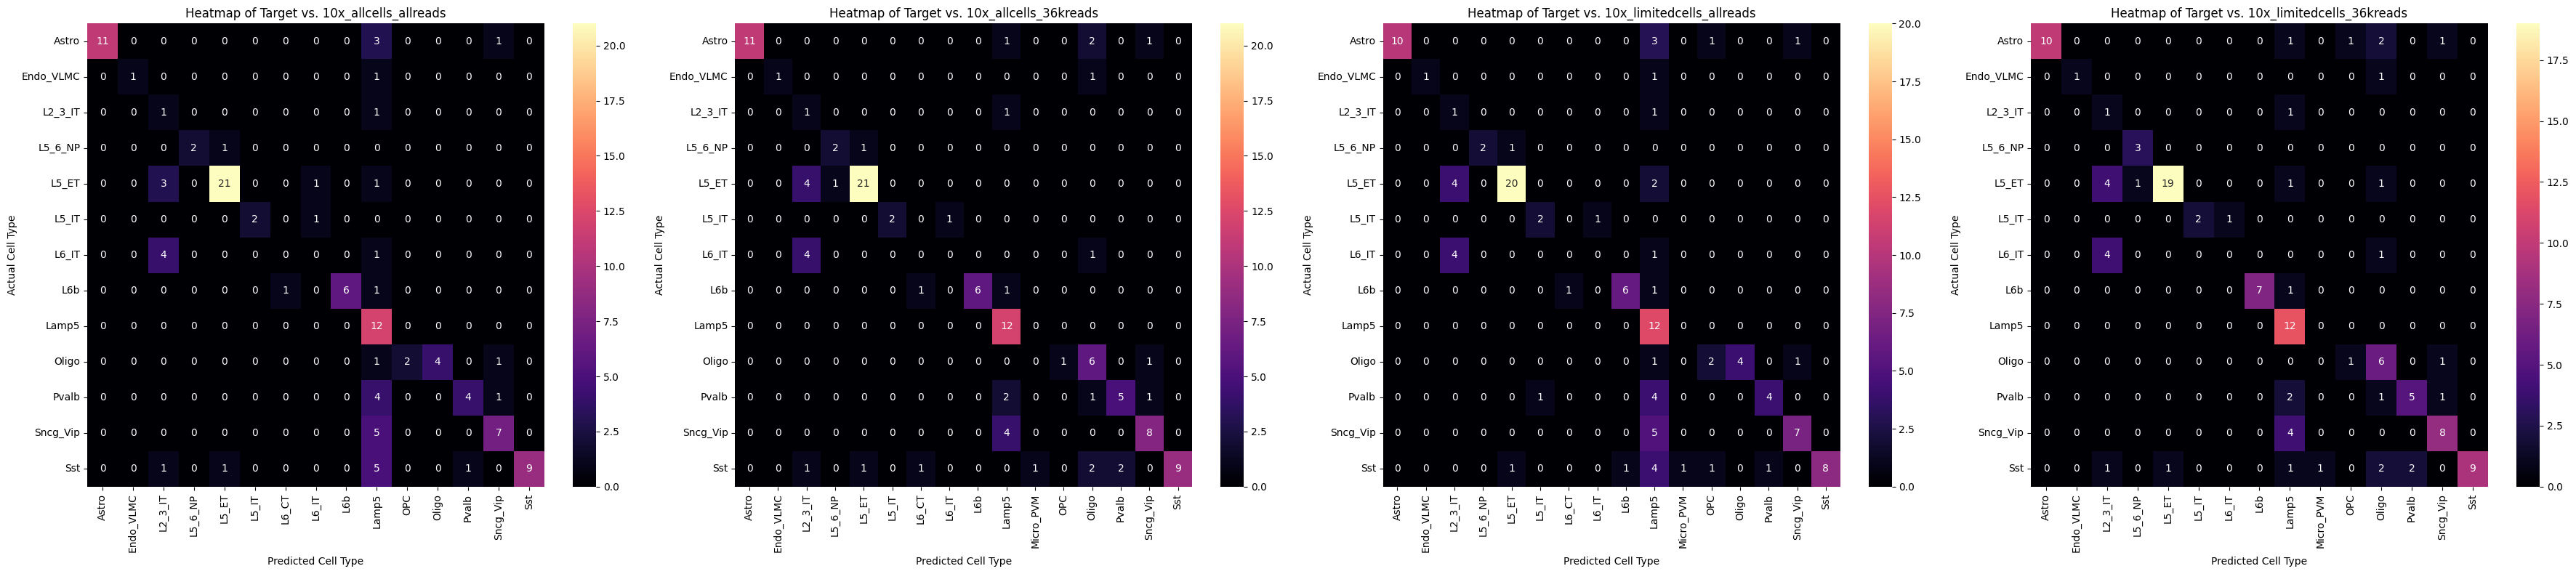

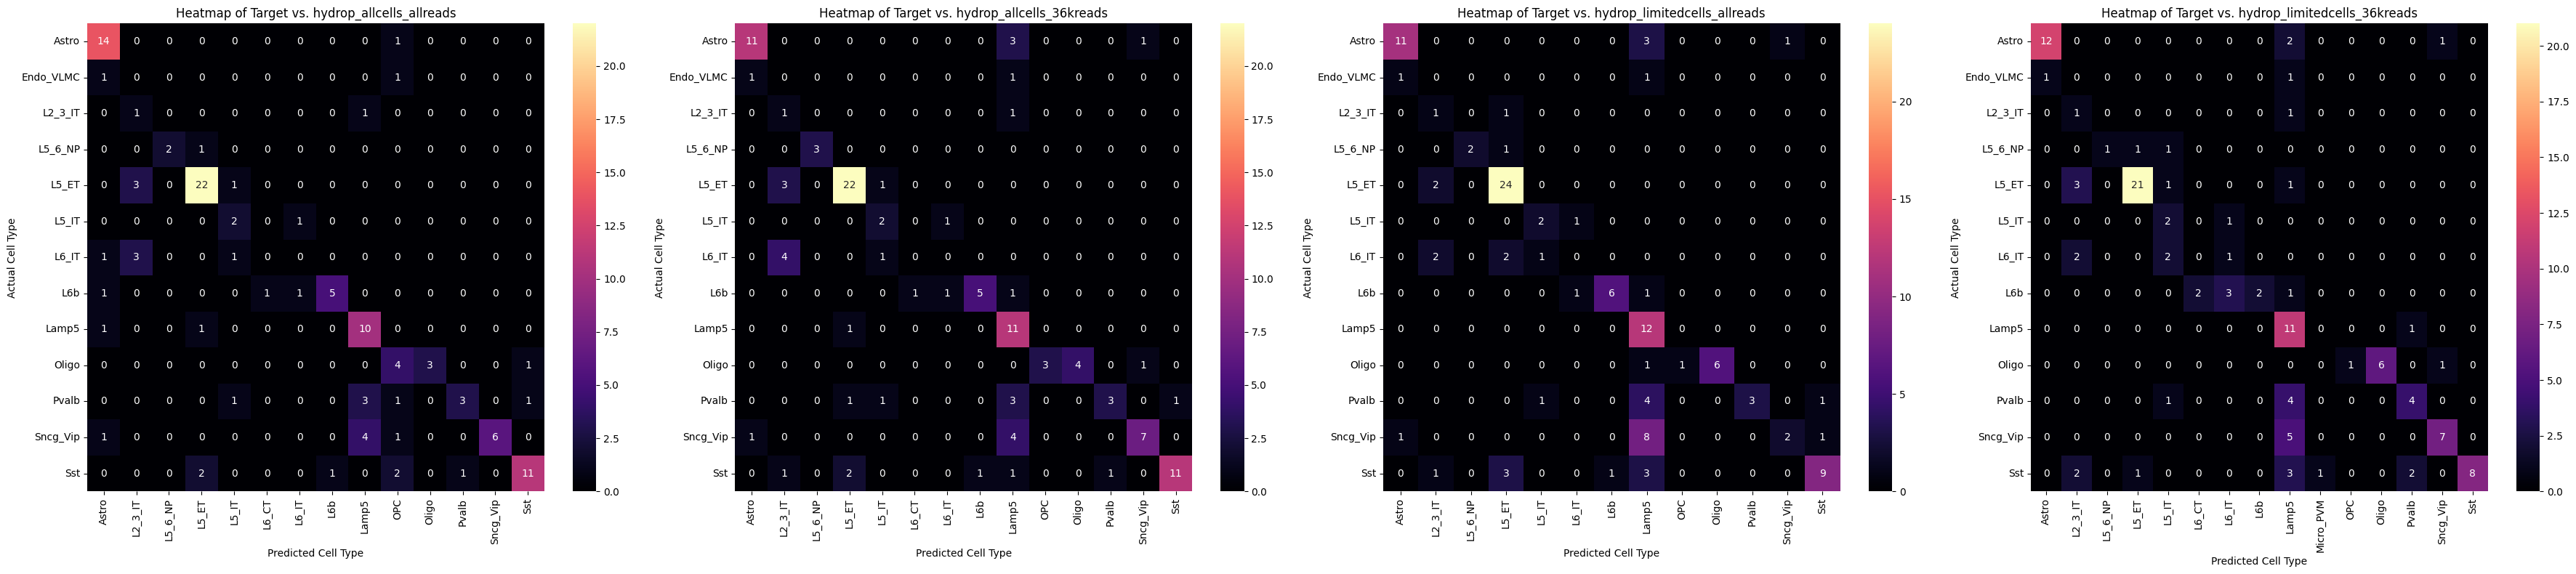

In [23]:
%matplotlib inline
# 10x models
tech_10x_models = [f"10x_{exp}" for exp in experiments]
plot_prediction_heatmaps(df_for_scoring, prediction_dict, tech_10x_models, figsize_scale=9, save_file="../../../plots/validated_biccn_enhancers_10x_models.pdf")

# Hydrop models  
tech_hydrop_models = [f"hydrop_{exp}" for exp in experiments]
plot_prediction_heatmaps(df_for_scoring, prediction_dict, tech_hydrop_models, figsize_scale=9, save_file="../../../plots/validated_biccn_enhancers_hydrop_models.pdf")

In [24]:
# Calculate specificity scores for each model
score_list = []
score_names = []

for tech in technologies:
    for exp in experiments:
        model_name = f"{tech}_{exp}"
        # Get raw predictions for this model
        raw_predictions = all_predictions[tech][exp]
        # Calculate specificity scores using scoring_utils function
        specificity_scores = calculate_specificity(raw_predictions)
        score_list.append(specificity_scores)
        score_names.append(model_name)

# Create ground truth binary labels based on enhancer annotations
gt_values = np.zeros((len(df_mouse), len(model_cell_types)), dtype=int)

for idx, row in df_mouse.iterrows():
    # Get target cell types
    first_target = row['target_ct_mapped']
    second_target = row['second_target_ct_mapped']
    
    # Find indices and set ground truth
    if first_target and first_target in model_cell_types:
        ct_idx = model_cell_types.index(first_target)
        gt_values[idx, ct_idx] = 1
        
    if second_target and second_target in model_cell_types:
        ct_idx = model_cell_types.index(second_target)
        gt_values[idx, ct_idx] = 1

print(f"Created ground truth matrix with shape: {gt_values.shape}")
print(f"Total positive labels: {np.sum(gt_values)}")

Created ground truth matrix with shape: (122, 16)
Total positive labels: 130


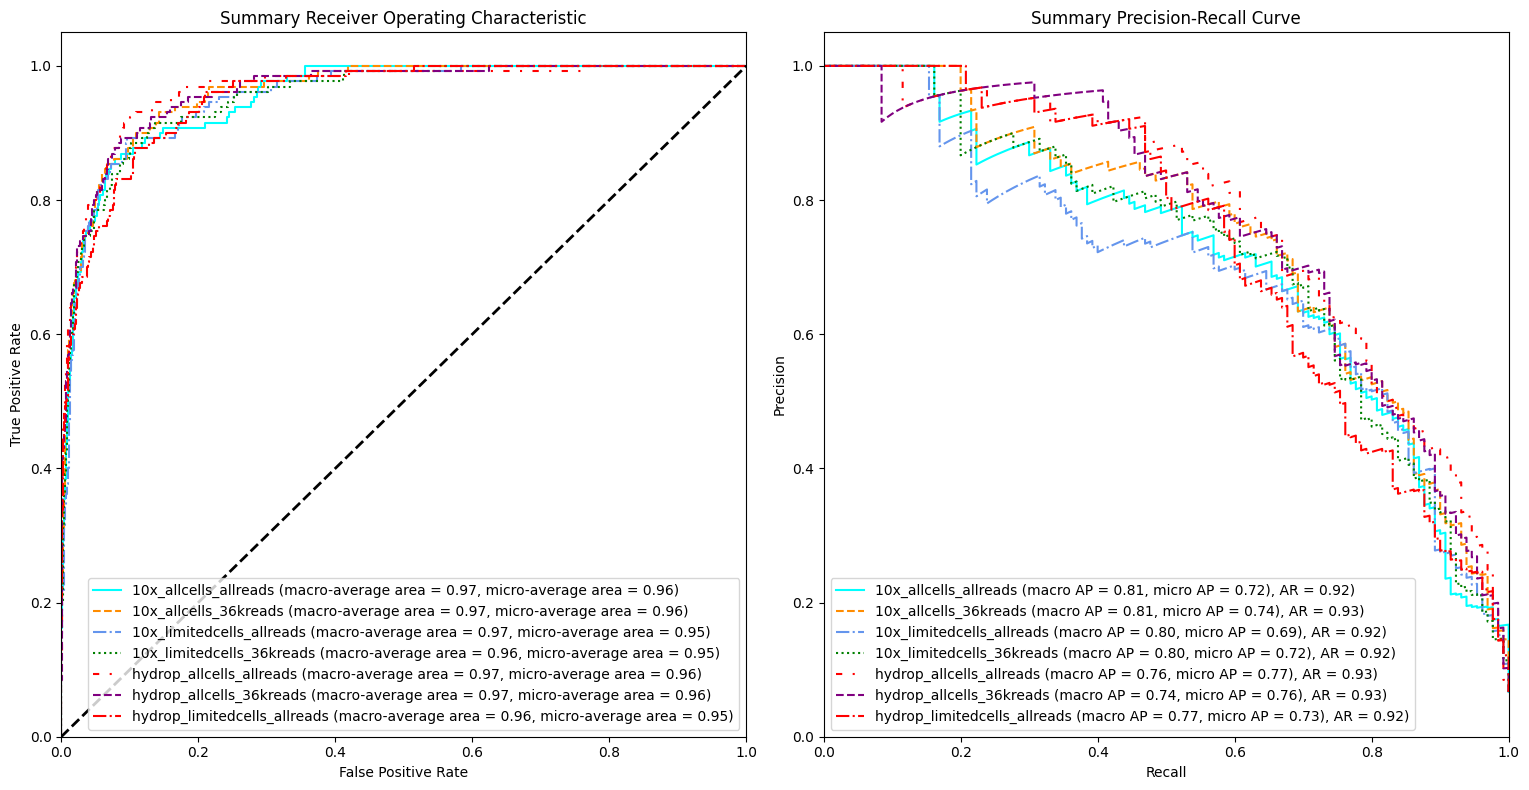

In [27]:
# Prepare data for ROC/PR plotting
models_data = []
for i, score in enumerate(score_list):
    model_data = {
        'name': score_names[i],
        'y_score': score,
        'y_true': gt_values
    }
    models_data.append(model_data)

# Generate ROC and PR curves
plot_summary_roc_aupr(models_data, file="../../../plots/validated_biccn_enhancers_roc_pr_curves.pdf")

In [30]:
# Create comprehensive comparison summary
print("COMPREHENSIVE ENHANCER VALIDATION ANALYSIS SUMMARY")
print("=" * 60)
print(performance_df.round(4))

print(f"\nTotal validated mouse enhancers analyzed: {len(df_mouse)}")
print(f"Cell types covered: {len(model_cell_types)}")
print(f"Scenarios compared: {len(model_names)}")

COMPREHENSIVE ENHANCER VALIDATION ANALYSIS SUMMARY
                              accuracy  precision  recall  f1_score
10x_allcells_allreads           0.6557     0.8170  0.6557    0.6913
10x_allcells_36kreads           0.6885     0.7922  0.6885    0.7126
10x_limitedcells_allreads       0.6311     0.8063  0.6311    0.6692
10x_limitedcells_36kreads       0.6803     0.7950  0.6803    0.7042
hydrop_allcells_allreads        0.6475     0.7541  0.6475    0.6672
hydrop_allcells_36kreads        0.6557     0.7437  0.6557    0.6712
hydrop_limitedcells_allreads    0.6393     0.7195  0.6393    0.6277
hydrop_limitedcells_36kreads    0.6230     0.7764  0.6230    0.6485

Total validated mouse enhancers analyzed: 122
Cell types covered: 16
Scenarios compared: 8
